In [2]:
import pandas as pd
import numpy as np

import string
import re
import datetime
#from datetime import date

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pylab import rcParams
import seaborn as sns

from jupyter_dash import JupyterDash as Dash
from dash import html 
from flask import Flask
import plotly.express as px

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
# create a new flask app
flask_app = Flask(__name__)

# create a new dash app built on that flask app
dash_app = Dash(__name__, server=flask_app)

# test app
dash_app.layout = html.P("Hello, World!")

In [3]:
dash_app.run_server(mode="inline", height=150, host="localhost", port=5000)

## Load Data

In [253]:
layoffs = pd.read_csv('data/layoffs.csv')
womp_national = pd.read_csv('data/Womply - National - Weekly.csv')
job_postings_national = pd.read_csv('data/Job Postings - National - Weekly.csv')

In [254]:
layoffs.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Google,SF Bay Area,Consumer,12000.0,0.06,2023-01-20,IPO,United States,26.0
1,Wayfair,Boston,Retail,1750.0,0.10,2023-01-20,IPO,United States,1700.0
2,Swiggy,Bengaluru,Food,380.0,0.06,2023-01-20,Unknown,India,3600.0
3,MediBuddy,Bengaluru,Healthcare,200.0,NaN,2023-01-20,Acquired,India,192.0
4,Vox Media,Washington D.C.,Media,130.0,0.07,2023-01-20,Series F,United States,307.0


In [4]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1860 non-null   object 
 1   location             1860 non-null   object 
 2   industry             1854 non-null   object 
 3   total_laid_off       1295 non-null   float64
 4   percentage_laid_off  1255 non-null   float64
 5   date                 1859 non-null   object 
 6   stage                1856 non-null   object 
 7   country              1860 non-null   object 
 8   funds_raised         1719 non-null   float64
dtypes: float64(3), object(6)
memory usage: 130.9+ KB


In [255]:
layoffs = layoffs.dropna(subset=['total_laid_off']).reset_index(drop=True)
display(layoffs.head())
layoffs.shape

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Google,SF Bay Area,Consumer,12000.0,0.06,2023-01-20,IPO,United States,26.0
1,Wayfair,Boston,Retail,1750.0,0.10,2023-01-20,IPO,United States,1700.0
2,Swiggy,Bengaluru,Food,380.0,0.06,2023-01-20,Unknown,India,3600.0
3,MediBuddy,Bengaluru,Healthcare,200.0,NaN,2023-01-20,Acquired,India,192.0
4,Vox Media,Washington D.C.,Media,130.0,0.07,2023-01-20,Series F,United States,307.0


(1414, 9)

In [140]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1350 non-null   object 
 1   location             1350 non-null   object 
 2   industry             1350 non-null   object 
 3   total_laid_off       1350 non-null   float64
 4   percentage_laid_off  1018 non-null   float64
 5   date                 1350 non-null   object 
 6   stage                1349 non-null   object 
 7   country              1350 non-null   object 
 8   funds_raised         1259 non-null   float64
dtypes: float64(3), object(6)
memory usage: 95.0+ KB


In [256]:
layoffs = layoffs.dropna(subset=['industry', 'stage']).reset_index(drop=True)
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1411 non-null   object 
 1   location             1411 non-null   object 
 2   industry             1411 non-null   object 
 3   total_laid_off       1411 non-null   float64
 4   percentage_laid_off  1054 non-null   float64
 5   date                 1411 non-null   object 
 6   stage                1411 non-null   object 
 7   country              1411 non-null   object 
 8   funds_raised         1315 non-null   float64
dtypes: float64(3), object(6)
memory usage: 99.3+ KB


In [257]:
layoffs[layoffs['percentage_laid_off'].isna()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
3,MediBuddy,Bengaluru,Healthcare,200.0,NaN,2023-01-20,Acquired,India,192.0
5,Karat,Seattle,HR,47.0,NaN,2023-01-20,Unknown,United States,169.0
6,Edifecs,Seattle,Healthcare,30.0,NaN,2023-01-20,Unknown,United States,1.0
8,Capital One,Washington D.C.,Finance,1100.0,NaN,2023-01-19,IPO,United States,NaN
9,WeWork,New York City,Real Estate,300.0,NaN,2023-01-19,IPO,United States,22200.0
...,...,...,...,...,...,...,...,...,...
1397,Peek,Salt Lake City,Travel,45.0,NaN,2020-03-20,Series B,United States,39.0
1399,Yonder,Austin,Media,18.0,NaN,2020-03-20,Series A,United States,16.0
1400,Bounce,Bengaluru,Transportation,120.0,NaN,2020-03-19,Series D,India,214.0
1403,Lola,Boston,Travel,34.0,NaN,2020-03-19,Series C,United States,81.0


In [ ]:
# need dataset with company size to get missing percentage laid off

In [8]:
display(womp_national.head())
womp_national.info()

,year,month,day_endofweek,merchants_all,revenue_all,merchants_professional,revenue_professional,merchants_health,revenue_health,merchants_food_accommodation,...,merchants_other_services,revenue_other_services,merchants_retail,revenue_retail,revenue_inclow,merchants_inclow,revenue_incmiddle,merchants_incmiddle,revenue_inchigh,merchants_inchigh
0,2020,1,12,0.00934,-0.005230,0.004080,-0.011100,0.00811,-0.00508,0.00998,...,0.00902,0.009850,0.01120,-0.01190,-0.005310,0.010500,0.007290,0.011800,0.004880,0.01060
1,2020,1,19,-0.00367,0.000584,-0.004330,-0.000985,-0.00287,-0.01670,-0.00220,...,-0.00380,0.000038,-0.00553,-0.01390,0.015900,-0.002260,-0.010600,-0.003320,-0.000157,-0.00172
2,2020,1,26,-0.00330,0.013900,0.000051,0.017900,-0.00288,0.02300,-0.00435,...,-0.00341,0.001940,-0.00323,0.01960,0.026800,-0.001270,0.018200,-0.002650,0.011300,-0.00213
3,2020,2,2,-0.00259,-0.001570,0.000253,0.002670,-0.00262,0.00464,-0.00369,...,-0.00234,-0.007390,-0.00305,0.00948,0.002370,-0.000103,0.000269,-0.000814,-0.000271,-0.00271
4,2020,2,9,-0.00444,-0.002180,-0.003930,0.010900,-0.00329,0.00727,-0.00351,...,-0.00557,-0.010200,-0.00485,-0.00721,0.000047,-0.002570,0.008100,-0.002160,0.001460,-0.00289


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          109 non-null    int64  
 1   month                         109 non-null    int64  
 2   day_endofweek                 109 non-null    int64  
 3   merchants_all                 109 non-null    float64
 4   revenue_all                   109 non-null    float64
 5   merchants_professional        109 non-null    float64
 6   revenue_professional          109 non-null    float64
 7   merchants_health              109 non-null    float64
 8   revenue_health                109 non-null    float64
 9   merchants_food_accommodation  109 non-null    float64
 10  revenue_food_accommodation    109 non-null    float64
 11  merchants_other_services      109 non-null    float64
 12  revenue_other_services        109 non-null    float64
 13  merch

In [258]:
date = []
for y, m, d in zip(womp_national.year, 
                   womp_national.month, 
                   womp_national.day_endofweek):
    
    date.append(datetime.date(y, m, d))

womp_national['date'] = date

In [10]:
display(job_postings_national.head())
job_postings_national.info()

,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889
1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060
2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640
3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465
4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               156 non-null    int64  
 1   month              156 non-null    int64  
 2   day_endofweek      156 non-null    int64  
 3   bg_posts           156 non-null    float64
 4   bg_posts_ss30      156 non-null    float64
 5   bg_posts_ss55      156 non-null    float64
 6   bg_posts_ss60      156 non-null    float64
 7   bg_posts_ss65      156 non-null    float64
 8   bg_posts_ss70      156 non-null    float64
 9   bg_posts_jz1       156 non-null    float64
 10  bg_posts_jzgrp12   156 non-null    float64
 11  bg_posts_jz2       156 non-null    float64
 12  bg_posts_jz3       156 non-null    float64
 13  bg_posts_jzgrp345  156 non-null    float64
 14  bg_posts_jz4       156 non-null    float64
 15  bg_posts_jz5       156 non-null    float64
dtypes: float64(13), int64(3)
m

In [259]:
# job_postings_national['date'] = []
# job_postings_national.loc[4, 'month']

# str(job_postings_national['year'][0]) + \
# '-' + str(job_postings_national['month'][0]) + \
# '-' + str(job_postings_national['day_endofweek'][0])

date = []
for y, m, d in zip(job_postings_national.year, 
                   job_postings_national.month, 
                   job_postings_national.day_endofweek):
    
    date.append(datetime.date(y, m, d))

job_postings_national['date'] = date

In [290]:
# Indeed Job Postings
# url: https://www.hiringlab.org/2022/06/09/data/

indeed_jobs = pd.read_csv('data/Hiring_Lab_subset_country_data_to_2023-01-20_overall.csv')
indeed_sectors = pd.read_csv('data/Hiring_Lab_full_country_data_to_2023-01-20_sector.csv')

In [291]:
display(indeed_jobs.head())
display(indeed_sectors.head())

,Unnamed: 0,Date,Country,Index Type,Seasonally adjusted percentage,Non-seasonally adjusted percentage
0,1,2020-02-01,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
1,2,2020-02-02,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.1
2,3,2020-02-03,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.1
3,4,2020-02-04,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.2
4,5,2020-02-05,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.1,100.3


,Unnamed: 0,Date,jobcountry,Sector,Index Type,Seasonally adjusted percentage,Non-seasonally adjusted percentage
0,1,2020-02-01,Australia,Accounting,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
1,2,2020-02-01,Australia,Administrative Assistance,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
2,3,2020-02-01,Australia,Agriculture and Forestry,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
3,4,2020-02-01,Australia,Architecture,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
4,5,2020-02-01,Australia,Arts and Entertainment,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0


### Twitter Data

In [244]:
import json
import requests
import re
import os
import tweepy

In [236]:
# function to get api key from secret file
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [245]:
# loading in api key
keys = get_keys("/Users/natalyadoris/.secret/twitter_api.json")
api_key = keys['api_key']
api_ks = keys['api_ks']
access_token = keys['access_token']
access_token_secret = keys['access_token_secret']
bearer_token = keys['bearer_token']

In [248]:
# token secret to authenticate as a user
client = tweepy.Client(
    consumer_key=api_key, consumer_secret=api_ks,
    access_token=access_token, access_token_secret=access_token_secret
)

In [ ]:
#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)

In [250]:
# can also authenticate with bearer_token
client = tweepy.Client(bearer_token)

In [ ]:
# uncomment to pull tweets (monthly cap 500k)
# response = client.search_recent_tweets("Tweepy", max_results=10)

In [251]:
tweets = response.data

# Each Tweet object has default ID and text fields
for tweet in tweets:
    print(tweet.id)
    print(tweet.text)

1617651260299300864
RT @3PySci_Nori: 【Tweepy】Twitter API v2：ツイート、返信（リプライ）、投票付きツイート、メディア付きツイート（v1.1）[Python] https://t.co/dAY1ObmFBn https://t.co/MNnK8JZlwd
1617647968848580611
RT @3PySci_Nori: 【Tweepy】Twitter API v2：ツイート、返信（リプライ）、投票付きツイート、メディア付きツイート（v1.1）[Python] https://t.co/dAY1ObmFBn https://t.co/MNnK8JZlwd
1617645955771404289
【Tweepy】Twitter API v2：ツイート、返信（リプライ）、投票付きツイート、メディア付きツイート（v1.1）[Python] https://t.co/dAY1ObmFBn https://t.co/MNnK8JZlwd
1617598820354777088
#Python #gamingcommunity 
#dataAnalytics #VR 
#SteamTrends #Tweepy 

https://t.co/DQIdMssElo ⬇️
1617569521975410706
Sending tweets from tweepy https://t.co/TyDVdx5jVe
1617563860713488386
Sending tweets from tweepy https://t.co/ZQiKGimzRJ
1617533366060089345
tweepy says hello :D
1617499666920386562
jika ada yg berkenan meminjamkan api twitter yg elevated buat percobaan tweepy... https://t.co/Vq2ojNalC7
1617477767825596417
RT @redmaytals: El suimanga asiático #NationalGeographic #Fotodeldia #Python #Tweepy https://t.co/lxbRZe

In [252]:
tweets

[<Tweet id=1617651260299300864 text='RT @3PySci_Nori: 【Tweepy】Twitter API v2：ツイート、返信（リプライ）、投票付きツイート、メディア付きツイート（v1.1）[Python] https://t.co/dAY1ObmFBn https://t.co/MNnK8JZlwd'>,
 <Tweet id=1617647968848580611 text='RT @3PySci_Nori: 【Tweepy】Twitter API v2：ツイート、返信（リプライ）、投票付きツイート、メディア付きツイート（v1.1）[Python] https://t.co/dAY1ObmFBn https://t.co/MNnK8JZlwd'>,
 <Tweet id=1617645955771404289 text='【Tweepy】Twitter API v2：ツイート、返信（リプライ）、投票付きツイート、メディア付きツイート（v1.1）[Python] https://t.co/dAY1ObmFBn https://t.co/MNnK8JZlwd'>,
 <Tweet id=1617598820354777088 text='#Python #gamingcommunity \n#dataAnalytics #VR \n#SteamTrends #Tweepy \n\nhttps://t.co/DQIdMssElo ⬇️'>,
 <Tweet id=1617569521975410706 text='Sending tweets from tweepy https://t.co/TyDVdx5jVe'>,
 <Tweet id=1617563860713488386 text='Sending tweets from tweepy https://t.co/ZQiKGimzRJ'>,
 <Tweet id=1617533366060089345 text='tweepy says hello :D'>,
 <Tweet id=1617499666920386562 text='jika ada yg berkenan meminjamkan api twitter yg elevated buat percoba

Potential key words:
- "job market"
- "layoffs"
- "economy"

### Census Data

In [292]:
import urllib.request, urllib.parse, urllib.error
import json

In [294]:
keys = get_keys("/Users/natalyadoris/.secret/census_api.json")
api_key = keys['api_key']

In [295]:
api_url = 'http://api.census.gov/data/timeseries/eits/bfs?get=cell_value,time_slot_id&'

In [377]:
#time = 'from 2022-Q1 to 2022-Q3'
error_data = ''
category_code = ''
seasonally_adj = ''
geo = ''
data_type_code = 'BA_BA' # number of business applications
time = 'from 2019 to 2023'
country = 'US'

In [382]:
# params
params = dict()

params['error_data'] = error_data
params['category_code'] = category_code
params['seasonally_adj'] = seasonally_adj
params['data_type_code'] = data_type_code
params['time'] = time
params['for'] = country

params['key'] = api_key

In [383]:
url = api_url + urllib.parse.urlencode(params)
print('Retreiving', url)

Retreiving http://api.census.gov/data/timeseries/eits/bfs?get=cell_value,time_slot_id&error_data=&category_code=&seasonally_adj=&data_type_code=BA_BA&time=from+2019+to+2023&for=US&key=03938ecbc1920954f5a8d26fa56b1ca6d1539c20


In [384]:
api_data = urllib.request.urlopen(url)

data = api_data.read().decode()
print('Retrieved', len(data), 'characters')

Retrieved 115100 characters


In [385]:
try:
    js = json.loads(data)
except:
    js = None
    
if not js:
    print('Failure to Retrieve')
    
def only_dict(data):
    
    return ast.literal_eval(data)

In [386]:
print(data)

[["cell_value","time_slot_id","error_data","category_code","seasonally_adj","data_type_code","time","us"],
["8580","0","no","NAICS42","no","BA_BA","2020-02","1"],
["12598","0","no","NAICS42","no","BA_BA","2020-08","1"],
["11311","0","no","NAICS51","yes","BA_BA","2020-07","1"],
["15105","0","no","NAICS72","no","BA_BA","2020-11","1"],
["12155","0","no","NAICS72","yes","BA_BA","2020-05","1"],
["19748","0","no","NAICS72","yes","BA_BA","2020-11","1"],
["13286","0","no","NAICS53","no","BA_BA","2020-04","1"],
["17369","0","no","NAICS53","no","BA_BA","2020-10","1"],
["62295","0","no","NAICSRET","no","BA_BA","2020-05","1"],
["57382","0","no","NAICSRET","no","BA_BA","2020-12","1"],
["82726","0","no","NAICSRET","yes","BA_BA","2020-06","1"],
["69369","0","no","NAICSRET","yes","BA_BA","2020-12","1"],
["38271","0","no","NAICS54","yes","BA_BA","2020-05","1"],
["45833","0","no","NAICS54","yes","BA_BA","2020-11","1"],
["39064","0","no","NAICS81","no","BA_BA","2022-05","1"],
["43674","0","no","NAICS23",

In [387]:
census_data = pd.DataFrame(js)
census_data.columns = census_data.iloc[0]
census_data = census_data.tail(-1).reset_index(drop=True)

In [388]:
census_data.head()

,cell_value,time_slot_id,error_data,category_code,seasonally_adj,data_type_code,time,us
0,8580,0,no,NAICS42,no,BA_BA,2020-02,1
1,12598,0,no,NAICS42,no,BA_BA,2020-08,1
2,11311,0,no,NAICS51,yes,BA_BA,2020-07,1
3,15105,0,no,NAICS72,no,BA_BA,2020-11,1
4,12155,0,no,NAICS72,yes,BA_BA,2020-05,1


Code dictionary linked [here](https://www.census.gov/econ/bfs/pdf/bfs_monthly_data_dictionary.pdf) 

In [389]:
census_data['category_code'].value_counts()

NAICS42     96
TOTAL       96
NAICSTW     96
NONAICS     96
NAICS11     96
NAICS55     96
NAICS61     96
NAICS21     96
NAICS56     96
NAICS22     96
NAICSMNF    96
NAICS51     96
NAICS52     96
NAICS71     96
NAICS23     96
NAICS81     96
NAICS54     96
NAICSRET    96
NAICS53     96
NAICS72     96
NAICS62     96
Name: category_code, dtype: int64

In [405]:
# sector dictionary

sectors = {'TOTAL': 'Total',
            'NAICS11': 'Agriculture',
            'NAICS21': 'Mining',
            'NAICS22': 'Utilities',
            'NAICS23': 'Construction',
            'NAICSMNF': 'Manufacturing',
            'NAICS42': 'Wholesale Trade',
            'NAICSRET': 'Retail Trade',
            'NAICSTW': 'Transportation and Warehousing',
            'NAICS51': 'Information', # closest to tech?
            'NAICS52': 'Finance and Insurance',
            'NAICS53': 'Real Estate',
            'NAICS54': 'Professional Services',
            'NAICS55': 'Management of Companies',
            'NAICS56': 'Administrative and Support',
            'NAICS61': 'Educational Services',
            'NAICS62': 'Health Care and Social Assistance',
            'NAICS71': 'Arts and Entertainment',
            'NAICS72': 'Accommodation and Food Services',
            'NAICS81': 'Other Services',
            'NAICS92': 'Public Administration',
            'NONAICS': 'No NAICS Assigned'
          }

In [406]:
census_data['sector'] = [sectors[code] for code in census_data['category_code']]
census_data.head()

,cell_value,time_slot_id,error_data,category_code,seasonally_adj,data_type_code,time,us,sector
177,18403,0,no,NAICS56,yes,BA_BA,2019-01-01,1,Administrative and Support
50,38202,0,no,NAICSRET,yes,BA_BA,2019-01-01,1,Retail Trade
308,4631,0,no,NAICS61,yes,BA_BA,2019-01-01,1,Educational Services
895,485,0,no,NAICS21,yes,BA_BA,2019-01-01,1,Mining
722,5291,0,no,NAICS11,no,BA_BA,2019-01-01,1,Agriculture


In [390]:
census_data['data_type_code'].value_counts()

BA_BA    2016
Name: data_type_code, dtype: int64

In [407]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016 entries, 177 to 1900
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cell_value      2016 non-null   int64         
 1   time_slot_id    2016 non-null   object        
 2   error_data      2016 non-null   object        
 3   category_code   2016 non-null   object        
 4   seasonally_adj  2016 non-null   object        
 5   data_type_code  2016 non-null   object        
 6   time            2016 non-null   datetime64[ns]
 7   us              2016 non-null   object        
 8   sector          2016 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 222.0+ KB


In [408]:
census_data['cell_value'] = [int(num) for num in census_data['cell_value']]
census_data['time'] = [pd.to_datetime(date) for date in census_data['time']]
census_data = census_data.sort_values(by='time')
census_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016 entries, 177 to 1900
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cell_value      2016 non-null   int64         
 1   time_slot_id    2016 non-null   object        
 2   error_data      2016 non-null   object        
 3   category_code   2016 non-null   object        
 4   seasonally_adj  2016 non-null   object        
 5   data_type_code  2016 non-null   object        
 6   time            2016 non-null   datetime64[ns]
 7   us              2016 non-null   object        
 8   sector          2016 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 157.5+ KB


In [409]:
# seasonally and non-seasonally adjusted
census_data_seas = census_data[census_data['seasonally_adj']=='yes']
census_data_no_seas = census_data[census_data['seasonally_adj']=='no']

In [435]:
# total apps or broken down by sector
census_data_seas_total = census_data_seas[census_data_seas['category_code']=='TOTAL']
census_data_seas_sectors = census_data_seas[census_data_seas['category_code'] != 'TOTAL']

In [436]:
# total apps or broken down by sector / non seasonally adjusted
census_data_no_seas_total = census_data_no_seas[census_data_no_seas['category_code']=='TOTAL']
census_data_no_seas_sectors = census_data_no_seas[census_data_no_seas['category_code'] != 'TOTAL']

### Simple Wall St Data

https://simplywall.st/markets/us/tech

In [477]:
sector = pd.read_csv('data/tech_sector.csv')
sector.head()

,Date,Market Cap,Revenue,Earnings,PE,Absolute PE,PS
0,"Mon, 30 Jan 2023",US$10.7t,US$2.2t,US$321.9b,24.5x,33.4x,4.8x
1,"Wed, 28 Dec 2022",US$9.6t,US$2.2t,US$327.5b,21.5x,29.5x,4.3x
2,"Fri, 25 Nov 2022",US$10.5t,US$2.2t,US$332.6b,22.2x,31.5x,4.7x
3,"Sun, 23 Oct 2022",US$9.8t,US$2.2t,US$341.2b,19.4x,28.8x,4.5x
4,"Tue, 20 Sep 2022",US$10.4t,US$2.2t,US$346.7b,20.1x,29.9x,4.7x


In [478]:
sector['Date'] = pd.to_datetime(sector['Date'])

In [479]:
sector['Market Cap'] = [val[3:-1] for val in sector['Market Cap']]
sector['Market Cap'] = [float(val)*1000000000000 for val in sector['Market Cap']]

In [480]:
sector['Revenue'] = [val[3:-1] for val in sector['Revenue']]
sector['Revenue'] = [float(val)*1000000000000 for val in sector['Revenue']]

In [481]:
sector['Earnings'] = [val[3:-1] for val in sector['Earnings']]
sector['Earnings'] = [float(val)*1000000000 for val in sector['Earnings']]

In [482]:
sector['PE'] = [float(val[:-1]) for val in sector['PE']]
sector['Absolute PE'] = [float(val[:-1]) for val in sector['Absolute PE']]
sector['PS'] = [float(val[:-1]) for val in sector['PS']]

In [483]:
display(sector.head())
sector.info()

,Date,Market Cap,Revenue,Earnings,PE,Absolute PE,PS
0,2023-01-30,1.070000e+13,2.200000e+12,3.219000e+11,24.5,33.4,4.8
1,2022-12-28,9.600000e+12,2.200000e+12,3.275000e+11,21.5,29.5,4.3
2,2022-11-25,1.050000e+13,2.200000e+12,3.326000e+11,22.2,31.5,4.7
3,2022-10-23,9.800000e+12,2.200000e+12,3.412000e+11,19.4,28.8,4.5
4,2022-09-20,1.040000e+13,2.200000e+12,3.467000e+11,20.1,29.9,4.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         23 non-null     datetime64[ns]
 1   Market Cap   23 non-null     float64       
 2   Revenue      23 non-null     float64       
 3   Earnings     23 non-null     float64       
 4   PE           23 non-null     float64       
 5   Absolute PE  23 non-null     float64       
 6   PS           23 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.4 KB


### NFP & Business Formations Data

In [485]:
bf_seas = pd.read_csv('data/business_formations_seasonal.csv')
bf_nonseas = pd.read_csv('data/business_formations_nonseasonal.csv')

nfp = pd.read_csv('data/nfp.csv')

In [486]:
bf_nonseas['month'] = [pd.to_datetime(month) for month in bf_nonseas['time']]
nfp['month'] = [pd.to_datetime(month) for month in nfp['date']]

### Credit Card Spending Data

In [488]:
affinity = pd.read_csv('data/Affinity - National - Daily.csv')
affinity.head()

,year,month,day,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,...,spend_s_all_q1,spend_s_all_q2,spend_s_all_q3,spend_s_all_q4,spend_s_inperson,spend_s_retail_no_grocery,spend_s_retail_w_grocery,spend_19_retail_no_grocery,spend_19_retail_w_grocery,provisional
0,2018,12,31,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
1,2019,1,1,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
2,2019,1,2,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
3,2019,1,3,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
4,2019,1,4,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0


In [489]:
affinity.tail()

,year,month,day,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,...,spend_s_all_q1,spend_s_all_q2,spend_s_all_q3,spend_s_all_q4,spend_s_inperson,spend_s_retail_no_grocery,spend_s_retail_w_grocery,spend_19_retail_no_grocery,spend_19_retail_w_grocery,provisional
1280,2022,12,18,w,.119,.000789,.113,.186,.103,.0568,...,.291,.231,.212,.168,-.0234,.643,.487,.696,.543,0
1281,2022,12,25,w,.21,.157,-.0508,.0362,.379,.135,...,.262,.203,.182,.145,-.0871,.599,.567,.651,.627,0
1282,2023,1,1,w,.124,.22,.116,.0569,.307,.108,...,.227,.182,.17,.139,.106,.293,.253,.335,.301,1
1283,2023,1,8,w,.167,.0934,.0712,.086,.288,.0845,...,.235,.181,.167,.131,.114,.229,.182,.269,.227,1
1284,2023,1,15,w,.166,.0764,.131,.323,.266,.0848,...,.218,.17,.158,.119,.098,.201,.155,.24,.199,1


In [491]:
date = []
for y, m, d in zip(affinity.year, 
                   affinity.month, 
                   affinity.day):
    
    date.append(datetime.date(y, m, d))

affinity['date'] = date

In [495]:
set(affinity.freq)

{'d', 'w'}

## EDA

In [498]:
fig = px.line(affinity[(affinity.freq=='d') & (affinity.provisional==0)], x="date", y="spend_all", title='Credit Card Spending')
fig.show()

In [411]:
fig = px.line(census_data_seas_total, x="time", y="cell_value", title='Business Formations')
fig.show()

In [413]:
fig = px.line(census_data_seas_sectors, 
              x="time", y="cell_value",
              title='Business Formations', 
              color='sector')
fig.show()

In [417]:
fig = px.line(census_data_seas_total[census_data_seas_total['time']>='2020'], 
              x="time", y="cell_value", 
              title='Business Formations, 2020 and Later')
fig.show()

In [416]:
fig = px.line(census_data_seas_sectors[census_data_seas_sectors['time']>='2020'], 
              x="time", y="cell_value",
              title='Business Formations, 2020 and later', 
              color='sector')
fig.show()

In [260]:
fig = px.line(job_postings_national, x="date", y="bg_posts", title='Job Postings')
fig.show()

In [12]:
fig = px.line(womp_national, x="date", y="merchants_all", 
              title='Percent change in number of small businesses open, relative to Jan 2020')
fig.show()

In [13]:
fig = px.line(womp_national, x="date", y="revenue_all", 
              title='Percent change in net revenue for small businesses, relative to Jan 2020')
fig.show()

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=womp_national['date'], y=womp_national['merchants_all'], name="Business Openings", mode='lines'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=womp_national['date'], y=womp_national['revenue_all'], name="Revenue", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Small Business Openings and Revenues, Relative to Jan 2020"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Small Business <b>Openings</b>", secondary_y=False)
fig.update_yaxes(title_text="Small Business <b>Revenues</b>", secondary_y=True)

fig.show()

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=womp_national['date'], y=womp_national['merchants_all'], 
               name="Business Openings", mode='lines'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=job_postings_national['date'], y=job_postings_national['bg_posts'], 
               name="Job Postings", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Small Business Openings and Job Postings, Relative to Jan 2020"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Small Business Openings", secondary_y=False)
fig.update_yaxes(title_text="Job Postings", secondary_y=True)

fig.show()

In [263]:
layoffs['day'] = [datetime.datetime.strptime(day, '%Y-%m-%d') for day in layoffs['date']]
layoffs['month'] = [pd.to_datetime(pd.to_datetime(day).strftime('%Y-%m')) for day in layoffs['date']]
# pd.to_datetime(datetime.datetime.strftime(layoffs['day'][0], "%m-%Y")) # another way

layoffs.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,day,month
0,Google,SF Bay Area,Consumer,12000.0,0.06,2023-01-20,IPO,United States,26.0,2023-01-20,2023-01-01
1,Wayfair,Boston,Retail,1750.0,0.10,2023-01-20,IPO,United States,1700.0,2023-01-20,2023-01-01
2,Swiggy,Bengaluru,Food,380.0,0.06,2023-01-20,Unknown,India,3600.0,2023-01-20,2023-01-01
3,MediBuddy,Bengaluru,Healthcare,200.0,NaN,2023-01-20,Acquired,India,192.0,2023-01-20,2023-01-01
4,Vox Media,Washington D.C.,Media,130.0,0.07,2023-01-20,Series F,United States,307.0,2023-01-20,2023-01-01


In [264]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   company              1411 non-null   object        
 1   location             1411 non-null   object        
 2   industry             1411 non-null   object        
 3   total_laid_off       1411 non-null   float64       
 4   percentage_laid_off  1054 non-null   float64       
 5   date                 1411 non-null   object        
 6   stage                1411 non-null   object        
 7   country              1411 non-null   object        
 8   funds_raised         1315 non-null   float64       
 9   day                  1411 non-null   datetime64[ns]
 10  month                1411 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(6)
memory usage: 121.4+ KB


In [265]:
layoffs_us = layoffs[layoffs['country']=='United States']
len(layoffs_us)

899

In [266]:
total_layoffs_by_date = layoffs[['total_laid_off', 'date']].groupby(by=['date']).sum().reset_index()
total_layoffs_by_date_us = layoffs_us[['total_laid_off', 'date']].groupby(by=['date']).sum().reset_index()

len(total_layoffs_by_date_us)

311

In [267]:
total_layoffs_by_date_us.head()

,date,total_laid_off
0,2020-03-11,75.0
1,2020-03-12,20.0
2,2020-03-13,14.0
3,2020-03-16,146.0
4,2020-03-18,4.0


In [268]:
# total number of people laid off
total_layoffs_by_month = layoffs[['total_laid_off', 'month']].groupby(by=['month']).sum().reset_index()
total_layoffs_by_month_us = layoffs_us[['total_laid_off', 'month']].groupby(by=['month']).sum().reset_index()

In [280]:
# total number of companies laying people off
layoff_count_by_month = layoffs[['total_laid_off', 'month']].groupby(by=['month']).count().reset_index()
layoff_count_by_month_us = layoffs_us[['total_laid_off', 'month']].groupby(by=['month']).count().reset_index()

In [269]:
total_layoffs_by_industry = layoffs[['total_laid_off', 'month', 'industry']]. \
groupby(by=['month', 'industry']).sum().reset_index()

total_layoffs_by_industry_us = layoffs_us[['total_laid_off', 'month', 'industry']]. \
groupby(by=['month', 'industry']).sum().reset_index()

In [270]:
total_layoffs_by_industry.head()

,month,industry,total_laid_off
0,2020-03-01,Aerospace,451.0
1,2020-03-01,Construction,60.0
2,2020-03-01,Consumer,840.0
3,2020-03-01,Data,230.0
4,2020-03-01,Education,50.0


In [271]:
fig = px.bar(total_layoffs_by_industry, x="month", y="total_laid_off", 
             color="industry", title='Total Layoffs U.S.')
fig.show() # too many colors to be helpful

In [418]:
industry_layoffs = layoffs[['industry', 'total_laid_off']].groupby(by=['industry']).sum().\
reset_index().sort_values(by='total_laid_off', ascending=False).reset_index(drop=True)

In [272]:
layoffs[['industry', 'total_laid_off']].groupby(by=['industry']).sum().\
reset_index().sort_values(by='total_laid_off', ascending=False).reset_index(drop=True)[:10]

,industry,total_laid_off
0,Consumer,42198.0
1,Retail,38549.0
2,Transportation,31184.0
3,Finance,24300.0
4,Food,21105.0
5,Other,18176.0
6,Healthcare,17856.0
7,Real Estate,16875.0
8,Travel,15729.0
9,Sales,11905.0


In [273]:
top_10_industries = layoffs[['industry', 'total_laid_off']].groupby(by=['industry']).sum().\
reset_index().sort_values(by='total_laid_off', ascending=False).reset_index(drop=True)[:10]

In [423]:
fig = px.bar(industry_layoffs,x = 'industry', y = 'total_laid_off', 
             color ='industry', text_auto='.2s',
             labels={
                     "industry": "Sectors",
                     "total_laid_off": "No. of laid off employees"
                     },
             template="plotly_white")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", 
                  cliponaxis=False)
fig.update_xaxes(tickangle=90)
fig.update_layout(height=700,
                  title="Number of Laid Off Employees Per Industry")
fig.show()

In [420]:
industry_layoffs_recent = layoffs[layoffs['month'] >= '06-2022'][['industry', 'total_laid_off']].\
groupby(by=['industry']).sum().reset_index().sort_values(by='total_laid_off', ascending=False).\
reset_index(drop=True)

In [422]:
fig = px.bar(industry_layoffs_recent,x = 'industry', y = 'total_laid_off', 
             color ='industry', text_auto='.2s',
             labels={
                     "industry": "Sectors",
                     "total_laid_off": "No. of laid off employees"
                     },
             template="plotly_white")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", 
                  cliponaxis=False)
fig.update_xaxes(tickangle=90)
fig.update_layout(height=700,
                  title="Number of Laid Off Employees Per Industry, Since June 2022")
fig.show()

In [424]:
industry_layoffs_old = layoffs[layoffs['month'] < '06-2022'][['industry', 'total_laid_off']].\
groupby(by=['industry']).sum().reset_index().sort_values(by='total_laid_off', ascending=False).\
reset_index(drop=True)

In [425]:
fig = px.bar(industry_layoffs_old,x = 'industry', y = 'total_laid_off', 
             color ='industry', text_auto='.2s',
             labels={
                     "industry": "Sectors",
                     "total_laid_off": "No. of laid off employees"
                     },
             template="plotly_white")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", 
                  cliponaxis=False)
fig.update_xaxes(tickangle=90)
fig.update_layout(height=700,
                  title="Number of Laid Off Employees Per Industry, Before June 2022")
fig.show()

In [275]:
layoffs_pct = layoffs.dropna(subset=['percentage_laid_off']).reset_index(drop=True)
layoffs_pct.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,day,month
0,Google,SF Bay Area,Consumer,12000.0,0.06,2023-01-20,IPO,United States,26.0,2023-01-20,2023-01-01
1,Wayfair,Boston,Retail,1750.0,0.10,2023-01-20,IPO,United States,1700.0,2023-01-20,2023-01-01
2,Swiggy,Bengaluru,Food,380.0,0.06,2023-01-20,Unknown,India,3600.0,2023-01-20,2023-01-01
3,Vox Media,Washington D.C.,Media,130.0,0.07,2023-01-20,Series F,United States,307.0,2023-01-20,2023-01-01
4,Citrine Informatics,SF Bay Area,Data,22.0,0.27,2023-01-20,Series C,United States,64.0,2023-01-20,2023-01-01


In [276]:
industry_top10_pct = layoffs[['industry', 'percentage_laid_off']].groupby(by=['industry']).mean() \
.reset_index().sort_values(by='percentage_laid_off', ascending=False) \
.reset_index(drop=True)[:10]

In [277]:
fig = px.bar(industry_top10_pct, x="industry", y="percentage_laid_off", 
             title='Layoffs by Industry, Average Percent Laid Off', 
             color_discrete_sequence=["purple"])
fig.show()

In [431]:
layoffs_by_co = layoffs[['company', 'total_laid_off', 'percentage_laid_off']].\
groupby(by=['company']).sum().reset_index()
layoffs_by_co_top_10 = layoffs_by_co.sort_values(by='total_laid_off', ascending=False)[:10]

In [432]:
fig = px.bar(layoffs_by_co_top_10, x="company", y="total_laid_off", 
             title='Companies with Most Layoffs', 
             color_discrete_sequence=["purple"])
fig.show()

In [433]:
# since June 2022
layoffs_by_co_recent = layoffs[layoffs['month'] >= '06-2022'][['company', 'total_laid_off', 'percentage_laid_off']].\
groupby(by=['company']).sum().reset_index()

layoffs_by_co_top_10_recent = layoffs_by_co_recent.sort_values(by='total_laid_off', ascending=False)[:10]

In [434]:
fig = px.bar(layoffs_by_co_top_10_recent, x="company", y="total_laid_off", 
             title='Companies with Most Layoffs Since June 2022', 
             color_discrete_sequence=["purple"])
fig.show()

In [23]:
#total_layoffs_by_month_us = layoffs_us[['total_laid_off', 'month']].groupby(by=['month']).agg([np.sum, 'count']).reset_index()
#total_layoffs_by_month_us.head() # need to flatten

In [279]:
fig = px.bar(total_layoffs_by_month_us, x="month", y="total_laid_off", title='Total Layoffs U.S.', 
             color_discrete_sequence=["red"])
fig.show()

In [281]:
fig = px.bar(layoff_count_by_month, x="month", y="total_laid_off", title='Layoff Count', 
             color_discrete_sequence=["red"])
fig.show()

In [32]:
fig = px.bar(total_layoffs_by_month, x="month", y="total_laid_off", title='Total Layoffs, Globally', 
             color_discrete_sequence=["red"])
fig.show()
# color for U.S. or International
# show count of companies 

In [282]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=total_layoffs_by_month_us['month'], 
           y=total_layoffs_by_month_us['total_laid_off'], 
           name="Layoffs"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=job_postings_national['date'], y=job_postings_national['bg_posts'], 
               name="Job Postings", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Layoffs and Job Postings"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Layoffs", secondary_y=False)
fig.update_yaxes(title_text="Job Postings, Relative to Jan 2020", secondary_y=True)

fig.show()

<AxesSubplot: >

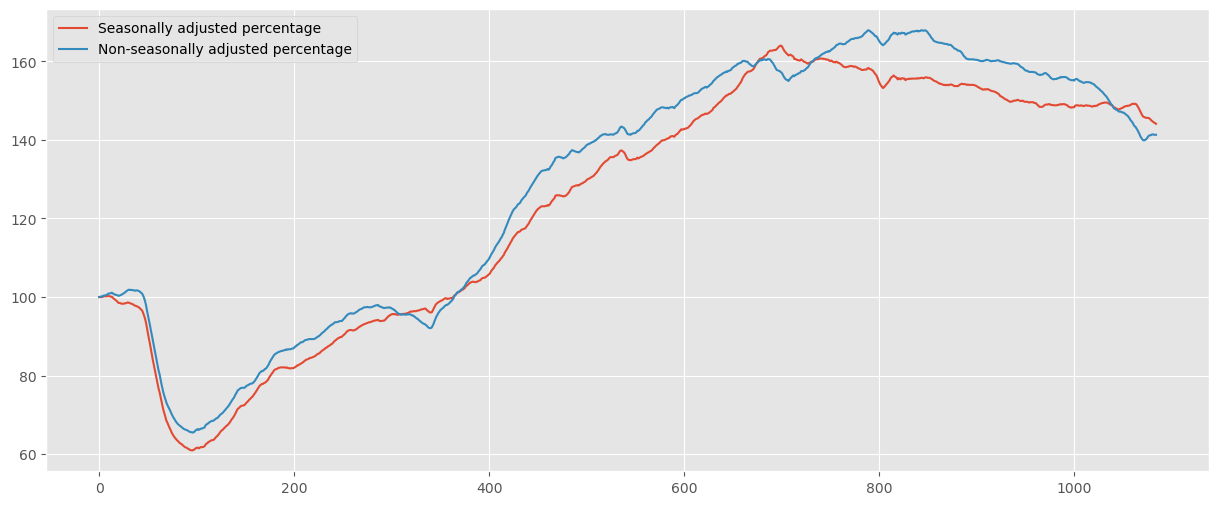

In [287]:
indeed_jobs[['Date', 'Seasonally adjusted percentage', 'Non-seasonally adjusted percentage']].plot()

In [289]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=indeed_jobs['Date'], y=indeed_jobs['Non-seasonally adjusted percentage'], 
               name="Indeed Job Postings", mode='lines'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=job_postings_national['date'], y=job_postings_national['bg_posts'], 
               name="Job Postings", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Indeed vs -- Job Postings, Relative to Jan 2020"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Indeed Job Postings", secondary_y=False)
fig.update_yaxes(title_text="Job Postings", secondary_y=True)

fig.show()

### Export Cleaned Data

In [230]:
total_layoffs_by_month.to_csv('data/monthly_layoffs.csv')
total_layoffs_by_month_us.to_csv('data/monthly_layoffs_us.csv')
total_layoffs_by_date.to_csv('data/daily_layoffs.csv')
total_layoffs_by_date_us.to_csv('data/daily_layoffs_us.csv')

job_postings_national.to_csv('data/job_postings.csv')

In [437]:
census_data_seas_total.to_csv('data/business_formations_seasonal.csv')
census_data_no_seas_total.to_csv('data/business_formations_nonseasonal.csv')

In [484]:
sector.to_csv('data/sector.csv')

## IDEAS

Final Outline:

- Job Postings Regression Model (data = indeed, target = postings (tech sector), features = twitter on state of the economy, other data related to the tech sector (avg revenues / etc), small business formations? w/ decision trees etc (predictive) or time series

- Classification model: will company layoff more than x percent of workforce? will company have layoffs more than once? will rate of layoffs grow or subside in sector? can I get sector specific data?? add twitter (200 tweet max per co)

- time series: economic indicators / govt data, several small time series to paint overall picture

- OR regression / time series predicting tech stock ETF

- need tech sector data - social media info (user activity, advertising dollars)

layoffs: want company or sector specific predictions

- predict future layoffs, job postings: time series forecasting :)
- get rid of outliers?
- watch time series videos :)
- where are the best opportunities? by industry, company size, location 
- PCA / clustering
- NLP twitter / sentiment: keywords like "job market" "layoffs" "economy"
- correlation between layoffs and job postings
- some kind of classification 

** https://github.com/mrethana/news_bias_final **
Labeling Data
To label objective vs subjective sentences I used the part of speech tagger in NLTK to flag any sentences with specific parts of speech commonly used in subjective sentences. These included:

predeterminers (all the kids).
comparative and superlative adverb (better, best).
comparative and superlative adjectives (bigger, biggest).
I then trained a simple Naive Bayes classifier with the sentences containing these parts of speech labeled as subjective.

- time in between jobs?
- best ways to get hired
- small vs medium vs large size businesses

1) predict future job postings
2) get granular - industry, company size, location
3) analyze layoff data 
4) user inputs, likelihood of you getting laid off? for example - give industry, company size
5) or, company input - is this company likely to lay people off soon?

- need database of tech company information - match company as input to a bunch of info about co. would be helpful too to add onto the layoff dataset
- mapping layoffs to opportunities
- what are sticky points? what prevents people from getting new job once they are laid off?
- word clusters for different job titles, i.e. data engineer / data modeler overlap

- more job postings data
- different time series for different sectors
- only use job posting data that would correlate to tech jobs?

- is company likely to do another round of layoffs? given already recently done a round of layoffs, how likely is it that they will need to cut more?
- what labels could I get for that: company that has done two rounds, break out test set. is there enough data? list of companies that have done one round, 1 or 0 for whether they did a second
- cutoff time for when second cut would need to be?


What is live/alternative data related to job market?
- tweets
- news articles
- job postings

Other ideas:
- A bunch of time series forecasts for diffrent economic indicators??
- time series for layoffs?
- comb companies that havent laid off with layoffs?
- classification - prob of more than one layoffs

## Data Sources

State of the tech labor market

Dashboard on plotly / dash with 3 tabs:
- 1 for state of economy / tech sector data viz
- layoffs analysis & classification - will company need more than one round?
- job postings time series / potenitally regression if enough data (monthly econ data so not a lot of data points)

- layoffs: layoffs.fyi  (kaggle)
- business formations: census api
- tech sector performance: simple wall st website scrape
- NFP: US bureau of labor statistics download
- individual stock / tech sector etf: yahoo finance api
- job postings: Indeed (csv from website) & Lightcast (kaggle)
- twitter data: twitter api or kaggle

next steps:
- revenue data for each company, profit margins etc (need subscription to crunchbase for that info)
- would love to find longer time series, pre 2020 for layoffs & job postings
- would like to find more data on the types of jobs being laid off specifically for each company, match that with job postings to see if there are enough job postings to support the laid off people

MVP:
    
- classifiction done (need to tune, smote seems pretty good)
- use time series for job postings / dynamic forecast
